In [ ]:
!pip install tensorflow tensorflow-probability

In [ ]:
!pip install tf-keras

In [6]:
import numpy as np
import pandas as pd
import scipy
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
tfd = tfp.distributions

In [7]:
# Parameters to be estimated
mu = tf.Variable(0.0, name='mu')
sigma = tf.Variable(1.0, name='sigma')

# Define the normal distribution with the current estimates for the parameters
normal_dist = tfd.Normal(loc=mu, scale=sigma)

2025-01-21 13:09:04.998577: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-01-21 13:09:04.998604: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: ml
2025-01-21 13:09:04.998624: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: ml
2025-01-21 13:09:04.998750: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 550.120.0
2025-01-21 13:09:04.998793: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 550.120.0
2025-01-21 13:09:04.998798: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:259] kernel version seems to match DSO: 550.120.0


In [8]:
# True parameters
true_mu = 5.0
true_sigma = 2.0

# Generate synthetic data
sampled_data = tfd.Normal(loc=true_mu, scale=true_sigma).sample(100)

In [12]:
def log_likelihood(data, distribution):
    return tf.reduce_sum(distribution.log_prob(data))


In [13]:
def neg_log_likelihood(data, distribution):
    return -log_likelihood(data, distribution)


In [14]:
optimizer = tf.optimizers.Adam(learning_rate=0.05)


In [15]:
for step in range(1000):
    with tf.GradientTape() as tape:
        tape.watch([mu, sigma])
        loss = neg_log_likelihood(sampled_data, normal_dist)
    gradients = tape.gradient(loss, [mu, sigma])
    optimizer.apply_gradients(zip(gradients, [mu, sigma]))
    if step % 100 == 0:
        print(f"Step {step}: mu = {mu.numpy()}, sigma = {sigma.numpy()}, loss = {loss.numpy()}")


Step 0: mu = 0.0499996691942215, sigma = 1.049999713897705, loss = 1709.5560302734375
Step 100: mu = 2.6298463344573975, sigma = 2.552239418029785, loss = 272.371826171875
Step 200: mu = 3.939300298690796, sigma = 2.6464648246765137, loss = 231.1068572998047
Step 300: mu = 4.767423152923584, sigma = 2.5107791423797607, loss = 217.43751525878906
Step 400: mu = 5.181198596954346, sigma = 2.3033602237701416, loss = 212.23789978027344
Step 500: mu = 5.312750339508057, sigma = 2.126072645187378, loss = 210.35740661621094
Step 600: mu = 5.333749294281006, sigma = 2.0250420570373535, loss = 209.87510681152344
Step 700: mu = 5.335134983062744, sigma = 1.9859386682510376, loss = 209.80950927734375
Step 800: mu = 5.335163593292236, sigma = 1.9749904870986938, loss = 209.8047332763672
Step 900: mu = 5.335163593292236, sigma = 1.9726022481918335, loss = 209.80450439453125


### Unsupervise Learning

In [77]:
import tensorflow_probability as tfp
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
tfd = tfp.distributions

In [81]:
# Number of components
num_components = 3

# Create variable for mixture weights
mix_probs = tf.Variable(tf.fill([num_components], value=1.0 / num_components), name='mix_probs')

# Create variables for component means and standard deviations
means = tf.Variable(tf.random.normal([num_components]), name='means')
stddevs = tf.Variable(tf.abs(tf.random.normal([num_components])) + 0.1, name='stddevs')  # Add a small constant to prevent zero

# Define the mixture model
components = [tfd.Normal(loc=means[i], scale=stddevs[i]) for i in range(num_components)]
gmm = tfd.Mixture(cat=tfd.Categorical(probs=mix_probs), components=components)


In [82]:
print("Data stats: Min:", np.min(data), "Max:", np.max(data), "Mean:", np.mean(data), "StdDev:", np.std(data))
print("Any NaNs in data:", np.any(np.isnan(data)))

Data stats: Min: -1.7859235 Max: 3.9263659 Mean: 0.5639325 StdDev: 1.4154118
Any NaNs in data: False


In [83]:
# Test with a single-component Gaussian
simple_gmm = tfd.Normal(loc=tf.Variable(0.0), scale=tf.Variable(1.0))
def simple_neg_log_likelihood():
    return -tf.reduce_mean(simple_gmm.log_prob(data))

# Test the simple model
with tf.GradientTape() as tape:
    loss = simple_neg_log_likelihood()
print("Initial test loss:", loss.numpy())


Initial test loss: 2.0796437


In [84]:
with tf.GradientTape() as tape:
    loss = neg_log_likelihood()
gradients = tape.gradient(loss, [mix_probs, means, stddevs])
print("Gradients:", gradients)


Gradients: [<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-1.0502605 ,  0.6791949 ,  0.37106538], dtype=float32)>, None, None]


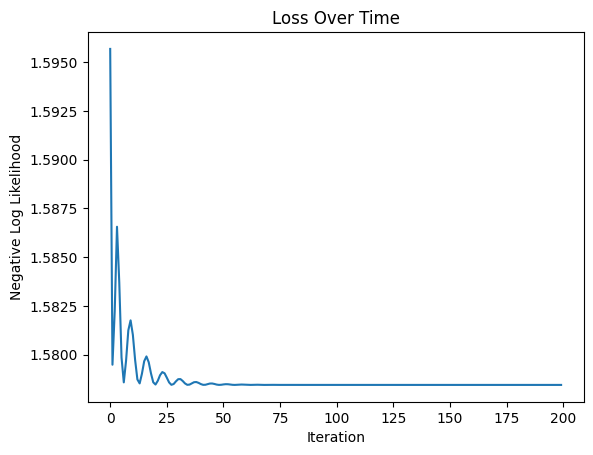

In [64]:
plt.plot(loss_history)
plt.title('Loss Over Time')
plt.xlabel('Iteration')
plt.ylabel('Negative Log Likelihood')
plt.show()


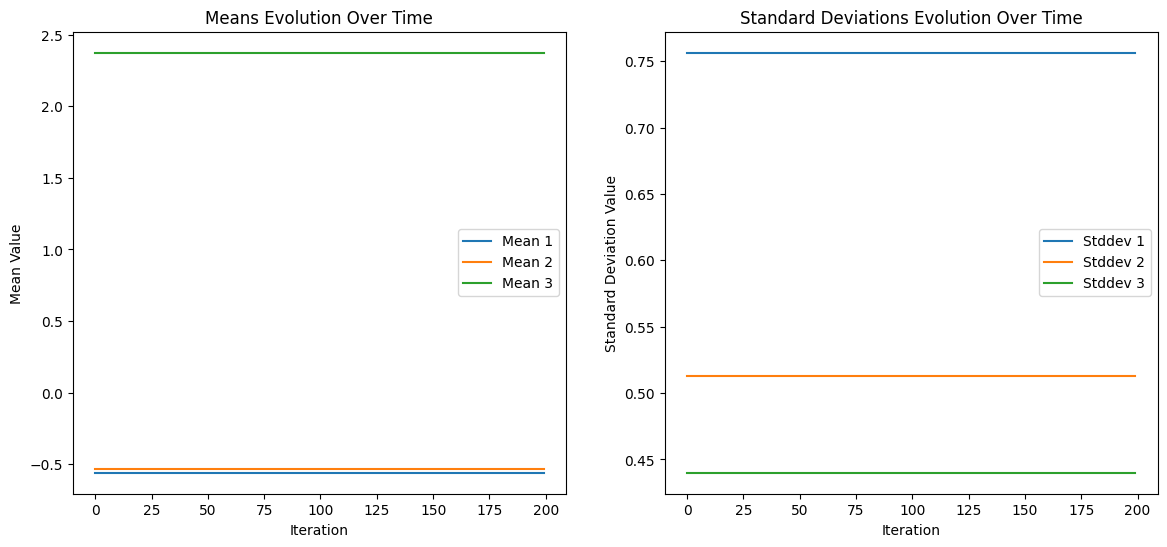

In [65]:
means_history = np.array(means_history)
stddevs_history = np.array(stddevs_history)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for i in range(means_history.shape[1]):
    plt.plot(means_history[:, i], label=f'Mean {i+1}')
plt.title('Means Evolution Over Time')
plt.xlabel('Iteration')
plt.ylabel('Mean Value')
plt.legend()

plt.subplot(1, 2, 2)
for i in range(stddevs_history.shape[1]):
    plt.plot(stddevs_history[:, i], label=f'Stddev {i+1}')
plt.title('Standard Deviations Evolution Over Time')
plt.xlabel('Iteration')
plt.ylabel('Standard Deviation Value')
plt.legend()

plt.show()


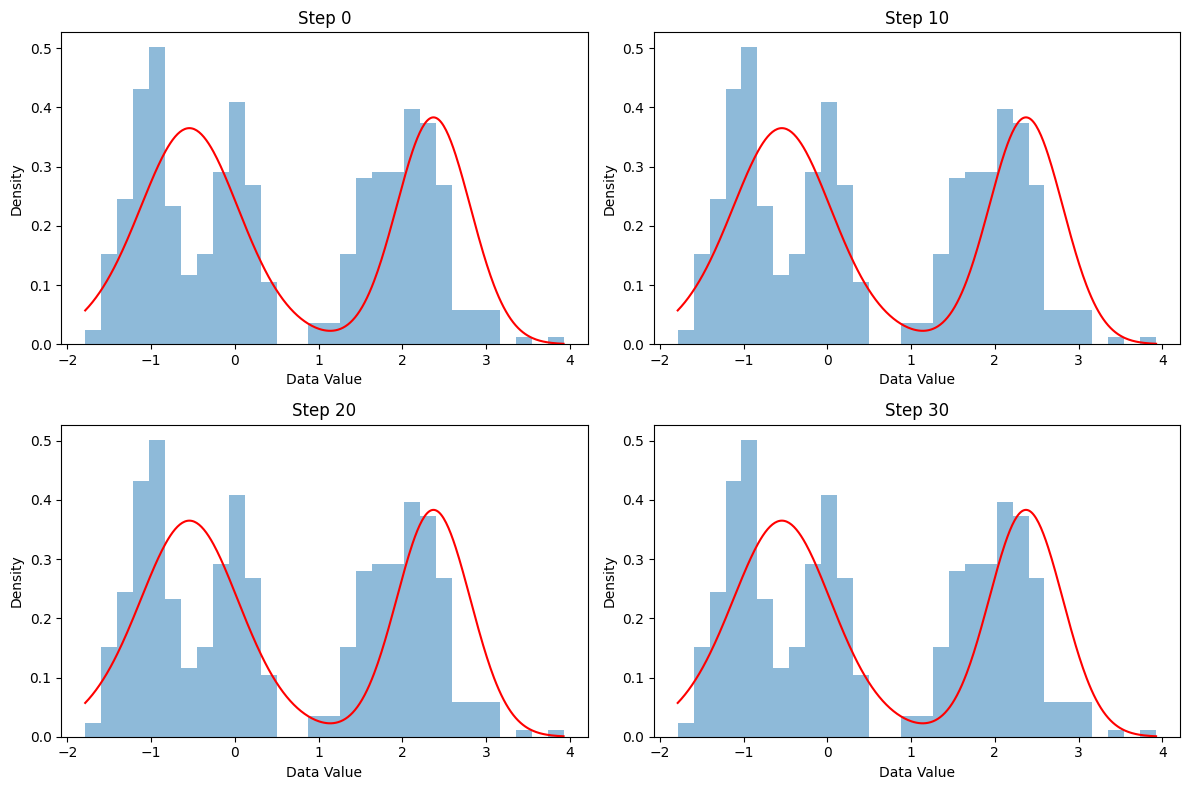

In [67]:
# Sample plotting at specific steps
sample_steps = [0, 10, 20, 30]  # Choose steps that you want to visualize
x = np.linspace(np.min(data), np.max(data), 400)

plt.figure(figsize=(12, 8))

for idx, step in enumerate(sample_steps):
    plt.subplot(2, 2, idx+1)
    density = np.exp(gmm.log_prob(x))
    plt.hist(data, bins=30, alpha=0.5, density=True)
    plt.plot(x, density, color='r')
    plt.title(f'Step {step}')
    plt.xlabel('Data Value')
    plt.ylabel('Density')

plt.tight_layout()
plt.show()
